<a href="https://colab.research.google.com/github/Suryaprasadindra/research/blob/main/checking_all_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score, recall_score, precision_score, f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from math import sqrt

# Define algorithms to use
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest Classifier": RandomForestClassifier(random_state=42)
}

regressors = {
    "Linear Regression": LinearRegression(),
    "Random Forest Regressor": RandomForestRegressor(random_state=42)
}

# Generate or load your dataset
X_class, y_class = make_classification(n_samples=10000, n_features=20, random_state=42)
X_regr, y_regr = make_regression(n_samples=10000, n_features=20, random_state=42)

# Function to preprocess data
def preprocess_data(X):
    # Remove duplicates
    df = pd.DataFrame(X).drop_duplicates().reset_index(drop=True)
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df)
    # PCA for multicollinearity (simple approach)
    pca = PCA(n_components=0.95)  # retain 95% variance
    X_pca = pca.fit_transform(X_scaled)
    return X_pca

# Function to perform sampling
def perform_sampling(X, y, method='random', k=5):
    if method == 'kmeans':
        kmeans = KMeans(n_clusters=k, random_state=42)
        clusters = kmeans.fit_predict(X)
        sampled_indices = []
        for i in range(k):
            cluster_indices = np.where(clusters == i)[0]
            sampled_indices.extend(np.random.choice(cluster_indices, size=int(len(cluster_indices) / k), replace=False))
        return X[sampled_indices], y[sampled_indices]
    else:
        indices = np.random.choice(range(len(y)), size=len(y)//2, replace=False)
        return X[indices], y[indices]

# Function to evaluate models and collect metrics
def evaluate_models(models, X_train, y_train, X_test, y_test, method, is_classification=True):
    results = []
    for name, model in models.items():
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        score = model.score(X_test, y_test)
        if is_classification:
            metrics = {
                "Sampling Method": method,
                "Model": name,
                "ROC AUC": roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]),
                "Recall": recall_score(y_test, predictions),
                "Precision": precision_score(y_test, predictions),
                "F1 Score": f1_score(y_test, predictions),
                "Training Accuracy": accuracy_score(y_train, model.predict(X_train)),
                "Testing Accuracy": accuracy_score(y_test, predictions)
            }
        else:
            metrics = {
                "Sampling Method": method,
                "Model": name,
                "MSE": mean_squared_error(y_test, predictions),
                "RMSE": sqrt(mean_squared_error(y_test, predictions)),
                "MAE": mean_absolute_error(y_test, predictions),
                "R^2": score,
                "Training Accuracy": model.score(X_train, y_train),
                "Testing Accuracy": score
            }
        results.append(metrics)
    return pd.DataFrame(results)

# Process and sample data
X_class_processed = preprocess_data(X_class)
y_class_processed = y_class.copy()
X_regr_processed = preprocess_data(X_regr)
y_regr_processed = y_regr.copy()

# Split the data
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class_processed, y_class_processed, test_size=0.2, random_state=42)
X_train_regr, X_test_regr, y_train_regr, y_test_regr = train_test_split(X_regr_processed, y_regr_processed, test_size=0.2, random_state=42)

# Perform samplings and evaluations for classification
X_train_class_random, y_train_class_random = perform_sampling(X_train_class, y_train_class, 'random')
X_train_class_kmeans, y_train_class_kmeans = perform_sampling(X_train_class, y_train_class, 'kmeans')
classification_results_random = evaluate_models(classifiers, X_train_class_random, y_train_class_random, X_test_class, y_test_class, 'Random Sampling', is_classification=True)
classification_results_kmeans = evaluate_models(classifiers, X_train_class_kmeans, y_train_class_kmeans, X_test_class, y_test_class, 'KMeans Sampling', is_classification=True)

# Perform samplings and evaluations for regression
X_train_regr_random, y_train_regr_random = perform_sampling(X_train_regr, y_train_regr, 'random')
X_train_regr_kmeans, y_train_regr_kmeans = perform_sampling(X_train_regr, y_train_regr, 'kmeans')
regression_results_random = evaluate_models(regressors, X_train_regr_random, y_train_regr_random, X_test_regr, y_test_regr, 'Random Sampling', is_classification=False)
regression_results_kmeans = evaluate_models(regressors, X_train_regr_kmeans, y_train_regr_kmeans, X_test_regr, y_test_regr, 'KMeans Sampling', is_classification=False)

# Combine results
final_results = pd.concat([classification_results_random, classification_results_kmeans, regression_results_random, regression_results_kmeans], ignore_index=True)
print(final_results)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


   Sampling Method                     Model   ROC AUC    Recall  Precision  \
0  Random Sampling       Logistic Regression  0.956077  0.899396   0.887786   
1  Random Sampling  Random Forest Classifier  0.973161  0.964789   0.926570   
2  KMeans Sampling       Logistic Regression  0.954908  0.911469   0.883041   
3  KMeans Sampling  Random Forest Classifier  0.969567  0.956740   0.922405   
4  Random Sampling         Linear Regression       NaN       NaN        NaN   
5  Random Sampling   Random Forest Regressor       NaN       NaN        NaN   
6  KMeans Sampling         Linear Regression       NaN       NaN        NaN   
7  KMeans Sampling   Random Forest Regressor       NaN       NaN        NaN   

   F1 Score  Training Accuracy  Testing Accuracy          MSE       RMSE  \
0  0.893553           0.889500          0.893500          NaN        NaN   
1  0.945293           1.000000          0.944500          NaN        NaN   
2  0.897030           0.897436          0.896000          Na

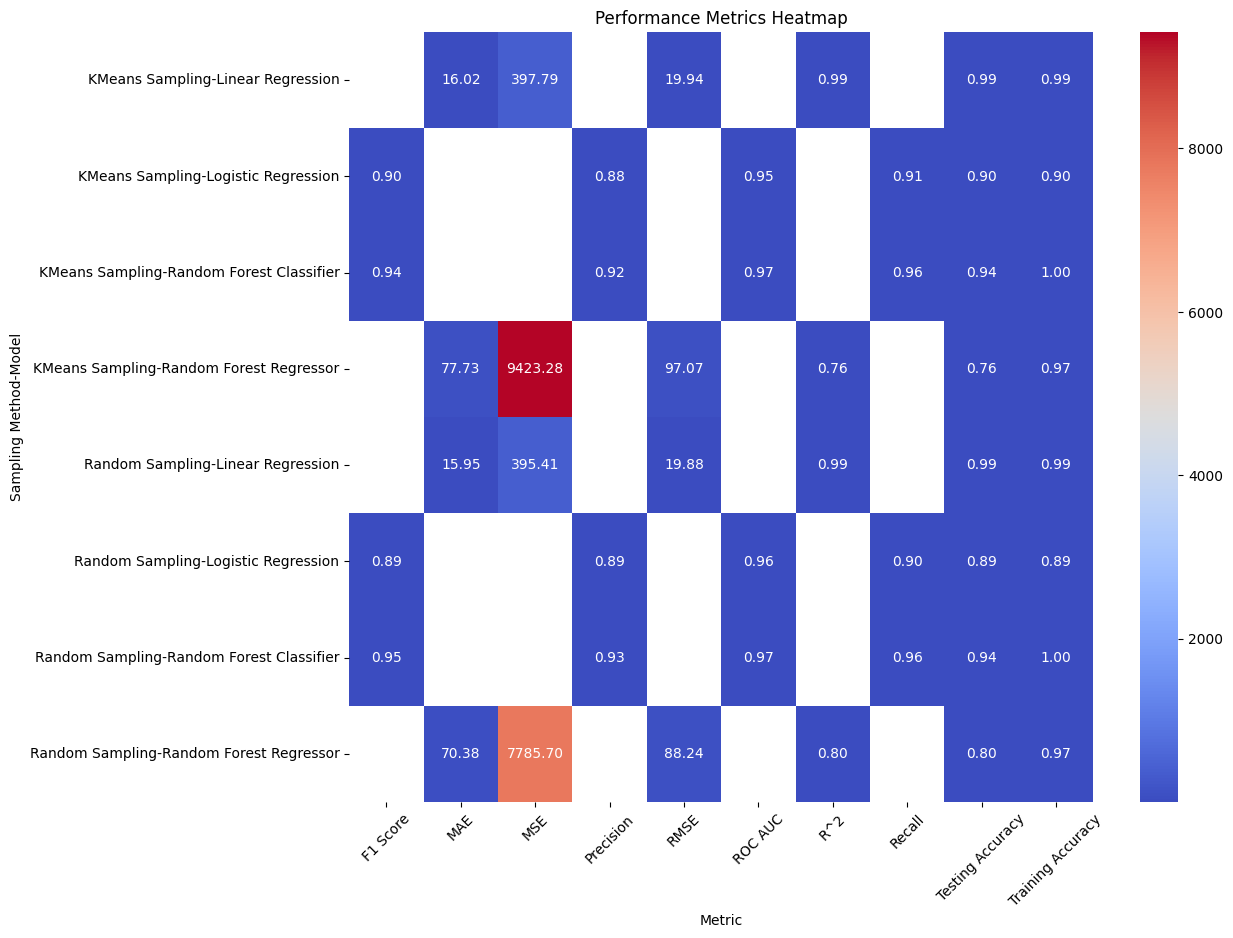

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to visualize the results in a heatmap
def visualize_results(df):
    # Pivot the DataFrame to format suitable for heatmap
    result_pivot = df.pivot_table(index=['Sampling Method', 'Model'], columns='Metric', values='Value', aggfunc='first')
    # Heatmap visualization
    plt.figure(figsize=(12, 10))
    sns.heatmap(result_pivot, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Performance Metrics Heatmap')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

# Prepare data for visualization
metrics_to_visualize = ['ROC AUC', 'Recall', 'Precision', 'F1 Score', 'Training Accuracy', 'Testing Accuracy', 'MSE', 'RMSE', 'MAE', 'R^2']
visual_data = final_results.melt(id_vars=['Sampling Method', 'Model'], value_vars=metrics_to_visualize, var_name='Metric', value_name='Value')

# Call the visualization function
visualize_results(visual_data)


In [15]:
# Assuming 'final_results' is a DataFrame with all the metrics collected
# after running the models with both sampling methods

# First, we reshape the DataFrame to have models, sampling methods, and metrics
# on separate columns
reshaped_df = final_results.set_index(['Sampling Method', 'Model']).stack().reset_index()
reshaped_df.columns = ['Sampling Method', 'Model', 'Metric', 'Value']

# We'll pivot the reshaped DataFrame to get the metrics across columns
# and models along the index
pivot_df = reshaped_df.pivot_table(index=['Model'], columns=['Sampling Method', 'Metric'], values='Value')

# Function to highlight the best value across a row
def highlight_best(s):
    is_max = s == s.max()
    return ['background-color: green' if v else '' for v in is_max]

# Apply the style function to the DataFrame and visualize it
styled_pivot_df = pivot_df.style.apply(highlight_best, axis=1)
styled_pivot_df


In [16]:
# Assuming 'final_results' is a DataFrame with all the metrics collected
# after running the models with both sampling methods

# Convert 'Value' to numeric if it's not already, handling non-numeric values
reshaped_df['Value'] = pd.to_numeric(reshaped_df['Value'], errors='coerce')

# Pivot the DataFrame to get the metrics across columns and models along the index
pivot_df = reshaped_df.pivot_table(index=['Model'], columns=['Sampling Method', 'Metric'], values='Value')

# Function to highlight the best values and good performances in a row
def highlight_best(s):
    # Highlight the maximum value in green and good performances in orange
    max_val = s.max()
    is_max = s == max_val
    # Assume a good performance if the value is within 1% of the max value
    is_good = s.apply(lambda x: abs(x - max_val) / max_val < 0.01 if max_val != 0 else False)
    # If all values are good (i.e., equal), we want to highlight them all
    all_good = is_good.all()
    return ['background-color: green' if v else 'background-color: orange' if (all_good or is_good[i]) else '' for i, v in enumerate(is_max)]

# Apply the style function to the DataFrame and visualize it
styled_pivot_df = pivot_df.style.apply(highlight_best, axis=1)
styled_pivot_df


hh


In [35]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score, recall_score, precision_score, f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from math import sqrt

# Define algorithms to use
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest Classifier": RandomForestClassifier(random_state=42)
}

regressors = {
    "Linear Regression": LinearRegression(),
    "Random Forest Regressor": RandomForestRegressor(random_state=42)
}

# Generate or load your dataset
X_class, y_class = make_classification(n_samples=10000, n_features=20, random_state=42)
X_regr, y_regr = make_regression(n_samples=10000, n_features=20, random_state=42)

# Function to preprocess data
def preprocess_data(X):
    # Remove duplicates
    df = pd.DataFrame(X).drop_duplicates().reset_index(drop=True)
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df)
    # PCA for multicollinearity (simple approach)
    pca = PCA(n_components=0.95)  # retain 95% variance
    X_pca = pca.fit_transform(X_scaled)
    return X_pca

# Function to perform sampling
def perform_sampling(X, y, method='random', k=5):
    if method == 'kmeans':
        kmeans = KMeans(n_clusters=k, random_state=42)
        clusters = kmeans.fit_predict(X)
        sampled_indices = []
        for i in range(k):
            cluster_indices = np.where(clusters == i)[0]
            sampled_indices.extend(np.random.choice(cluster_indices, size=int(len(cluster_indices) / k), replace=False))
        return X[sampled_indices], y[sampled_indices]
    else:
        indices = np.random.choice(range(len(y)), size=len(y)//2, replace=False)
        return X[indices], y[indices]

# Function to evaluate models and collect metrics
def evaluate_models(models, X_train, y_train, X_test, y_test, method, is_classification=True):
    results = []
    for name, model in models.items():
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        score = model.score(X_test, y_test)
        if is_classification:
            metrics = {
                "Sampling Method": method,
                "Model": name,
                "ROC AUC": roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]),
                "Training Accuracy": accuracy_score(y_train, model.predict(X_train)),
                "Testing Accuracy": accuracy_score(y_test, predictions)
            }
        else:
            metrics = {
                "Sampling Method": method,
                "Model": name,
                "MSE": mean_squared_error(y_test, predictions),
                "RMSE": sqrt(mean_squared_error(y_test, predictions)),
                "MAE": mean_absolute_error(y_test, predictions),
                "R^2": score,
                "Training Accuracy": model.score(X_train, y_train),
                "Testing Accuracy": score
            }
        results.append(metrics)
    return pd.DataFrame(results)

# Process and sample data
X_class_processed = preprocess_data(X_class)
y_class_processed = y_class.copy()
X_regr_processed = preprocess_data(X_regr)
y_regr_processed = y_regr.copy()

# Split the data
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class_processed, y_class_processed, test_size=0.2, random_state=42)
X_train_regr, X_test_regr, y_train_regr, y_test_regr = train_test_split(X_regr_processed, y_regr_processed, test_size=0.2, random_state=42)

# Perform samplings and evaluations for classification
X_train_class_random, y_train_class_random = perform_sampling(X_train_class, y_train_class, 'random')
X_train_class_kmeans, y_train_class_kmeans = perform_sampling(X_train_class, y_train_class, 'kmeans')
classification_results_random = evaluate_models(classifiers, X_train_class_random, y_train_class_random, X_test_class, y_test_class, 'Random Sampling', is_classification=True)
classification_results_kmeans = evaluate_models(classifiers, X_train_class_kmeans, y_train_class_kmeans, X_test_class, y_test_class, 'KMeans Sampling', is_classification=True)

# Perform samplings and evaluations for regression
X_train_regr_random, y_train_regr_random = perform_sampling(X_train_regr, y_train_regr, 'random')
X_train_regr_kmeans, y_train_regr_kmeans = perform_sampling(X_train_regr, y_train_regr, 'kmeans')
regression_results_random = evaluate_models(regressors, X_train_regr_random, y_train_regr_random, X_test_regr, y_test_regr, 'Random Sampling', is_classification=False)
regression_results_kmeans = evaluate_models(regressors, X_train_regr_kmeans, y_train_regr_kmeans, X_test_regr, y_test_regr, 'KMeans Sampling', is_classification=False)

# Combine results
final_results = pd.concat([classification_results_random, classification_results_kmeans, regression_results_random, regression_results_kmeans], ignore_index=True)

# Data visualization section is needed here to implement the desired performance comparison table, which has been outlined in the previous messages.



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
